In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


import polars as pl

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

import pickle


In [2]:
data = pd.read_csv('dataset/Network_anomaly_data.csv')


data = data.drop(columns=['protocoltype', 'service', 'flag'])

data['attack'] = data['attack'].apply(lambda x: 0 if x == 'normal' else 1)




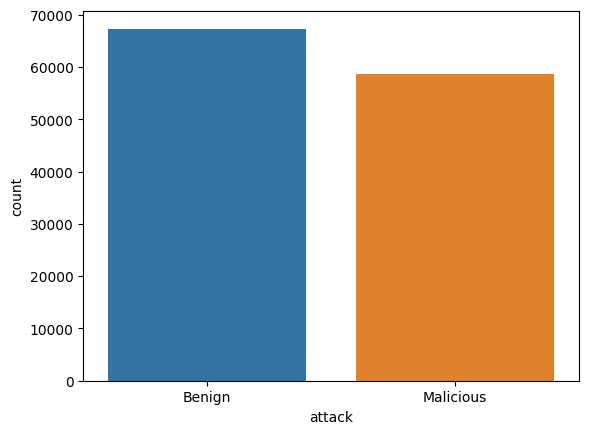

In [3]:
data_anomaly = data[data['attack'] == 1]
data_normal = data[data['attack'] == 0]

df_count = pl.DataFrame({'attack': ['Benign', 'Malicious'], 'count': [data_normal.shape[0], data_anomaly.shape[0]]})
sns.barplot(x='attack', y='count', hue='attack', data=df_count)
plt.show()


In [4]:

target_column = 'attack'  
correlation_threshold = 0.5


correlation_matrix = data.corr()

high_corr_features = correlation_matrix[target_column][correlation_matrix[target_column].abs() > correlation_threshold].index.tolist()

high_corr_features.remove(target_column)

#high_corr_features.remove("loggedin")
high_corr_features.remove("srvserrorrate")
high_corr_features.remove("samesrvrate")
high_corr_features.remove("dsthostsrvcount")
high_corr_features.remove("dsthostsamesrvrate")
high_corr_features.remove("dsthostserrorrate")
high_corr_features.remove("dsthostsrvserrorrate")
#high_corr_features.remove("count")




print("Highly correlated features with the target:")
print(high_corr_features)


Highly correlated features with the target:
['loggedin', 'count', 'serrorrate']


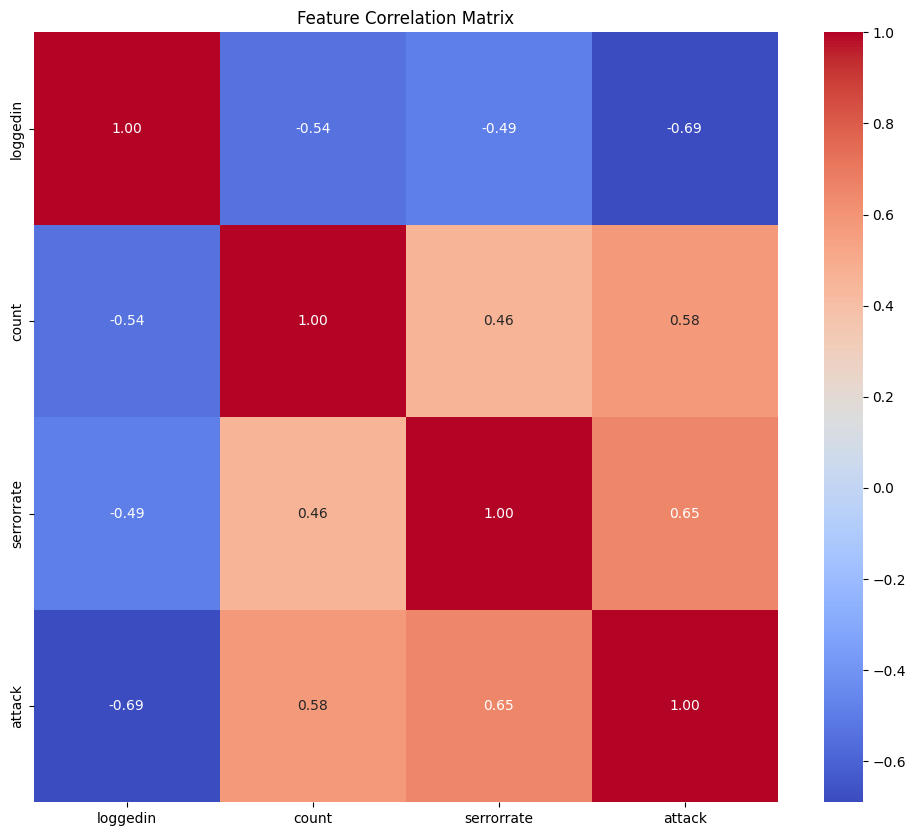

In [5]:
filtered_data = data[high_corr_features + [target_column]]




correlation_matrix = filtered_data.corr()



# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [6]:
X = data.drop('attack', axis=1)  
y = data['attack']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#pca = PCA(n_components=4)  
#X_pca = pca.fit_transform(X_scaled)


In [7]:
Y = filtered_data['attack']
X = filtered_data.drop(columns=['attack'])

print(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

        loggedin  count  serrorrate
0              0      2         0.0
1              0     13         0.0
2              0    123         1.0
3              1      5         0.2
4              1     30         0.0
...          ...    ...         ...
125968         0    184         1.0
125969         0      2         0.0
125970         1      1         0.0
125971         0    144         1.0
125972         1      1         0.0

[125973 rows x 3 columns]


In [8]:
#scaler = MinMaxScaler()
#X_train = scaler.fit_transform(X_train)
#X_test  = scaler.transform(X_test)

/opt/homebrew/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

If you really know what your doing, you can silence this warning with the warning module
or by setting POLARS_ALLOW_FORKING_THREAD=1.

  pid = os.fork()


              precision    recall  f1-score   support

      normal     0.8397    0.8861    0.8623      6751
      attack     0.8595    0.8047    0.8312      5847

    accuracy                         0.8483     12598
   macro avg     0.8496    0.8454    0.8467     12598
weighted avg     0.8489    0.8483    0.8478     12598



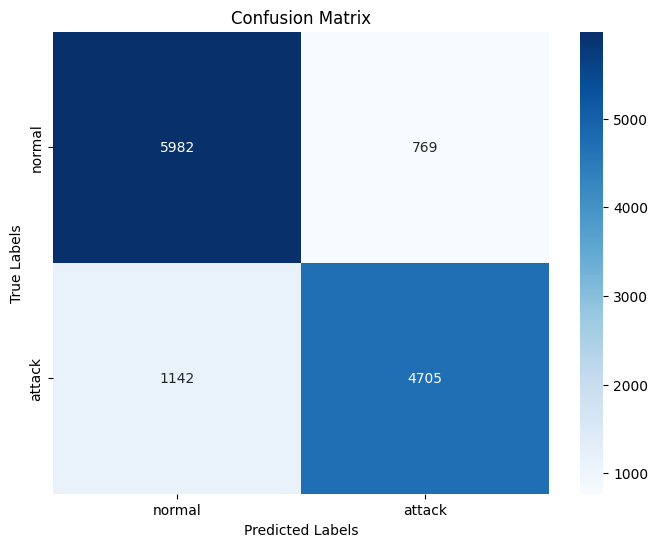

In [9]:
clf = LogisticRegression(class_weight='balanced', random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['normal', 'attack'], digits=4))


labels = ['normal', 'attack']
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show() 

with open("logistic_regression_model.pkl", "wb") as f:
    pickle.dump(clf, f)



In [10]:
svm_clf = SVC(class_weight='balanced', random_state=42)

svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['normal', 'attack'], digits=4))

SVM Classification Report:
              precision    recall  f1-score   support

      normal     0.8058    0.8981    0.8495      6751
      attack     0.8644    0.7501    0.8032      5847

    accuracy                         0.8294     12598
   macro avg     0.8351    0.8241    0.8263     12598
weighted avg     0.8330    0.8294    0.8280     12598



In [11]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam',
                         random_state=42, max_iter=500)

mlp_clf.fit(X_train, y_train)

y_pred_mlp = mlp_clf.predict(X_test)

print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_mlp, target_names=['normal', 'attack'], digits=4))

Neural Network Classification Report:
              precision    recall  f1-score   support

      normal     0.7968    0.9696    0.8748      6751
      attack     0.9532    0.7146    0.8168      5847

    accuracy                         0.8512     12598
   macro avg     0.8750    0.8421    0.8458     12598
weighted avg     0.8694    0.8512    0.8479     12598

